# Reconstruction of estimated glacier states

In order to reduce uncertainties from unknown inital conditions, we developped a method to reconstruct estimated glacier states. The method consists of three main steps: generation of glacier states, identification of glacier candidates and their evaluation and will be explained in detail in the upcomming paper. This notebook shows how to apply the developped method. A proper installation of OGGM and all dependencies are required to run this method. Knowledge on how to run OGGM is required!

### Set-up

In [1]:
import os
import salem

from core import *
from plots import *

from oggm import cfg, workflow,utils
#pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline
# settings for plots
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =15
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize']= 15 
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['figure.figsize'] = 10,10


cfg.initialize()

# path to working and plot directory
WORKING_DIR = '/home/juliaeis/Dokumente/OGGM/work_dir/reconstruction/paper2'
cfg.PATHS['working_dir'] = WORKING_DIR
utils.mkdir(cfg.PATHS['working_dir'], reset=False)
cfg.PATHS['plot_dir'] = os.path.join(cfg.PATHS['working_dir'], 'plots')
utils.mkdir(cfg.PATHS['plot_dir'], reset=False)


# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True

# How many grid points around the glacier?
cfg.PARAMS['border'] = 200

# Set to True for operational runs
cfg.PARAMS['continue_on_error'] = True

# We use intersects
db = utils.get_rgi_intersects_region_file(version='61', region='11')
cfg.set_intersects_db(db)

cfg.PARAMS['run_mb_calibration'] = True
cfg.PARAMS['optimize_inversion_params'] = False

/home/juliaeis/.pyvirtualenvs/oggm_env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
2019-02-05 13:36:19: oggm.cfg: Using configuration file: /home/juliaeis/oggm-juliaeis/oggm/params.cfg


### Glacier outlines and climate data
The glacier outlines are obtained from the Randolph Glacier Inventory. We selected 66 glaciers in the Oetztal Alps to test the skill of our method. As climate data we use the HISTALP dataset.  

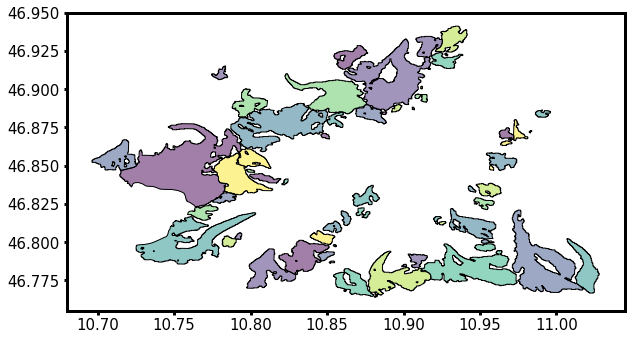

In [2]:
# read shapefile with 66 glaciers in the Oetztal Alps
rgidf = salem.read_shapefile('rgi/oetztal.shp')

# sort for efficient using
rgidf = rgidf.sort_values('Area', ascending=False)
rgidf.plot()

# Use HISTALP climate file
cfg.PARAMS['baseline_climate'] = 'HISTALP'

### Preprocessing of OGGM
The function "preprocessing(gdirs)" runs all required steps of OGGM, before we can start to reconstruct the glacier. This includes e.g. the calculation of the flowlines, the processing of the HISTALP dataset, and the inversion.Cause to large computational costs, we will focus from now on one glacier (the smallest one), only.

In [25]:
# initization of OGGM
gdirs = workflow.init_glacier_regions(rgidf)

# this function only needs to be run ONCE
preprocessing(gdirs)
gdir = gdirs[-1]

### Synthetic experiments
We performed synthetic experiments to test the performance of our method. As the method is still under developpment, we recommend to use the method only in combination with the experiments. Otherwise it is not guaranteed, that the glacier candidates converge towards the observation and wrong reconstructions could result. A method to ensure this convergence will follow soon.  

In [26]:
 # add to BASENAMES
try:
    _doc = 'contains observed and searched glacier from synthetic experiment to find intial state'
    cfg.BASENAMES['synthetic_experiment'] = ('synthetic_experiment.pkl', _doc)
except:
    pass

# creates the experiments for a list of glacier in parallel
synthetic_experiments_parallel([gdir])


2019-02-05 14:34:34: oggm.core.flowline: (RGI60-11.00873) run_random_climate
2019-02-05 14:34:34: oggm.core.flowline: (RGI60-11.00873) trying default time stepping scheme.
2019-02-05 14:34:37: oggm.core.flowline: (RGI60-11.00873) default time stepping was successful!
2019-02-05 14:34:37: oggm.core.flowline: (RGI60-11.00873) run_from_climate_data_experiment
2019-02-05 14:34:37: oggm.core.flowline: (RGI60-11.00873) trying default time stepping scheme.
2019-02-05 14:34:38: oggm.core.flowline: (RGI60-11.00873) default time stepping was successful!


A glacier for the year 1850 is created by running a random climate task with the temperature bias -1 for 400 years. This glacier will be run forward from 1850 to 2000. The resulting glacier is from now on the observed glacier. 

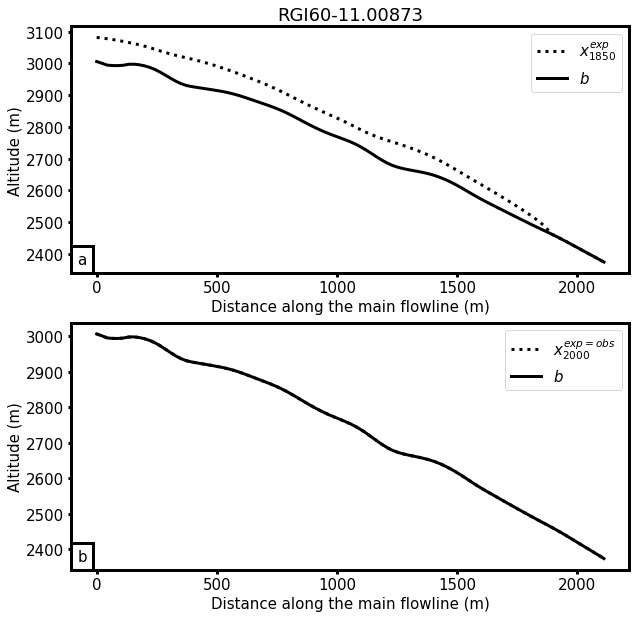

In [15]:
# reads the expermient model
ep = gdir.get_filepath('model_run', filesuffix='_experiment')
ex_mod = FileModel(ep)

# plots cross section along the flowline in 1850 and 2000
plot_experiment(gdir,ex_mod,1850,cfg.PATHS['plot_dir'])


These plots show, that no ice left in 2000. Nevertheless, we try to reconstruct this glacier.  

### Reconstruction of the state in 1850
To reconstruct the glacier you need to call the function `find_possible_glaciers(gdir,y0,ye,n)`, with the GlacierDirectory `gdir`, the year of the searched state `y0`, the year of the obersvation `ye` and `n` the number of glacier candidates to test. For `n`, we recommend a value in the rage $[100,200]$. Only for demonstration, we reduce this value in this example in order save computation time. 


In [17]:
results = find_possible_glaciers(gdir, 1850, 2000, 20)
results['volume'] = results.model.apply(lambda x: x.volume_m3)
results

,model,objective,temp_bias,time,volume
0,<oggm.core.flowline.FileModel object at 0x7f74...,0.0,-1.40,366,3.033149e+07
1,<oggm.core.flowline.FileModel object at 0x7f74...,0.0,-1.35,276,2.122991e+07
2,<oggm.core.flowline.FileModel object at 0x7f74...,0.0,-1.35,293,2.426725e+07
3,<oggm.core.flowline.FileModel object at 0x7f74...,0.0,-1.25,279,1.819476e+07
4,<oggm.core.flowline.FileModel object at 0x7f74...,0.0,-1.20,385,1.516278e+07
5,<oggm.core.flowline.FileModel object at 0x7f74...,0.0,-1.10,281,1.213726e+07
6,<oggm.core.flowline.FileModel object at 0x7f74...,0.0,-0.95,328,9.105648e+06
7,<oggm.core.flowline.FileModel object at 0x7f74...,0.0,-0.90,363,6.064323e+06
8,<oggm.core.flowline.FileModel object at 0x7f75...,0.0,-0.85,345,2.997980e+06
9,<oggm.core.flowline.FileModel object at 0x7f74...,0.0,-2.10,254,5.162110e+07


The output is a `panda.DataFrame()` with following informations for each tested glacier candidate: OGGM's FileModel of the past climate run from yr to ye, the objective (also called fitness) value, and the temperature bias and time point from the random climate runs to identify later which candidates was picked. From the FileModel all required inforamtions (e.g. volume, area, length, surface elevations at grid points) can be obtained. All previous model_runs will be saved and stored in a new directory named by the year. If the function should be run a second time for the same glacier (e.g. with more candidates), the algorithm first check, if this model_run was already done and reads the corresponding FileModel, if this is the case. Hereby it is avoided that the same runs will be run twice. 

### Graphics
#### Glacier candidates
The function `plot_candidates` plots the random climate tasks and the identified glacier candidates, colored by their Fitness value. 

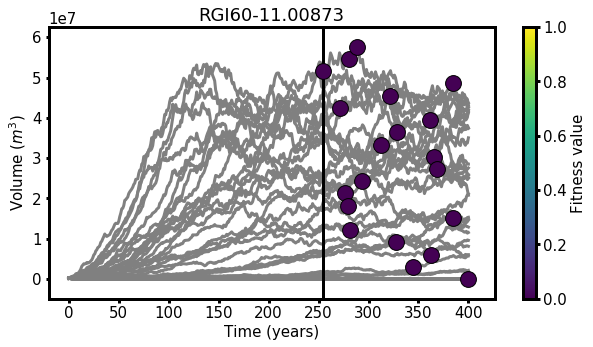

In [18]:
plot_candidates(gdir, results, 1850, cfg.PATHS['plot_dir'])

#### Cross-Section colored by Fitness value
The function `plot_surface` plot the cross-Section along the main flowline of all glacier candidates at 1850 and 2000, as well as the volumes between 1850-2000. 

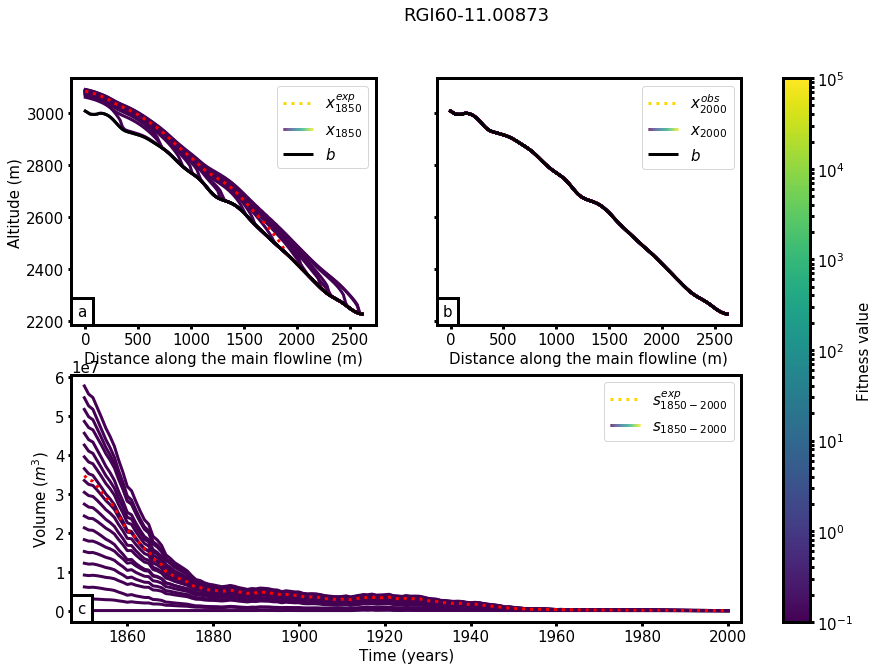

In [19]:
plot_surface(gdir,results, ex_mod,1850,cfg.PATHS['plot_dir'])

The plots already show, that all tested glaciers are possible. That is because all candidates converge to one state  in 1960 and thus all fitness values are zero. That's why we now test a later year. Let's say 1920. Additionally we increase n, the number of candidates.

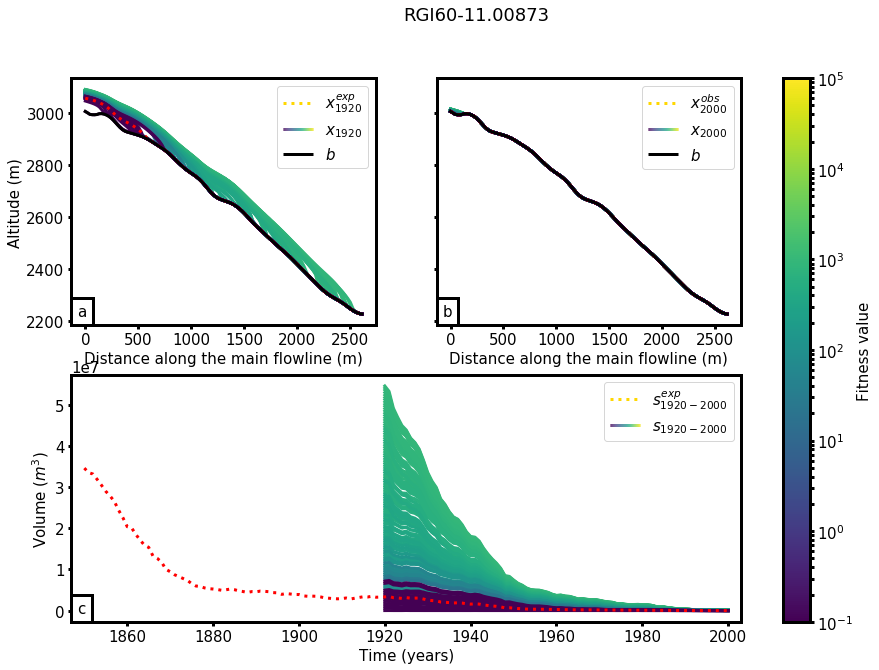

In [27]:
results = find_possible_glaciers(gdir, 1920, 2000, 100)
results['volume'] = results.model.apply(lambda x: x.volume_m3)
plot_surface(gdir,results, ex_mod,1920,cfg.PATHS['plot_dir'])

For 1920 the number of possible glacier states ist already reduced. We accept glaciers with a fitness value smaller than 100. For this example, 21 of the 100 tested glaciers fullfil this criteria:

In [22]:
results [results['objective']<= 100]

,model,objective,temp_bias,time,volume
53,<oggm.core.flowline.FileModel object at 0x7f74...,50.355213,-0.60,340,1.157578e+07
56,<oggm.core.flowline.FileModel object at 0x7f74...,62.918458,-0.50,250,8.822898e+06
57,<oggm.core.flowline.FileModel object at 0x7f74...,65.223816,-0.50,306,9.925065e+06
58,<oggm.core.flowline.FileModel object at 0x7f74...,22.407546,-0.45,277,7.717763e+06
59,<oggm.core.flowline.FileModel object at 0x7f74...,28.709740,-0.45,305,8.302161e+06
60,<oggm.core.flowline.FileModel object at 0x7f74...,70.366181,-0.40,286,1.047965e+07
62,<oggm.core.flowline.FileModel object at 0x7f74...,54.247352,-0.40,351,9.390221e+06
63,<oggm.core.flowline.FileModel object at 0x7f74...,0.000000,-0.40,379,7.175643e+06
64,<oggm.core.flowline.FileModel object at 0x7f74...,0.000000,-0.40,382,6.617247e+06
65,<oggm.core.flowline.FileModel object at 0x7f74...,0.000000,-0.35,251,4.407973e+06


#### Median state 
We also found out that the median state of the 5% quantile of all glaciers with a fitness value smaller than 100 fits well with the experient. To create a plot, showing the interquantile range and the median state you can use the function `plot_median`:

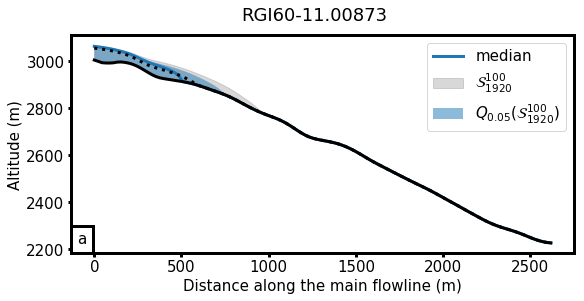

In [23]:
med_mod = plot_median(gdir,results,ex_mod,1920, cfg.PATHS['plot_dir'])

The grey area, shows all glacier states with a fitness value smaller than 100. The blue area is the 5% quantile and the blue line represents the median state. Additionally this function returns the FileModel of the median state to be able to use it for other runs. This is the best estimate of the reconstructed state in 1920. 

### Reconstructability over time
As the example above already shows the reconstructability depends on the year of the reconstruction. That's why we can run the algorihms for different starting times y0. This is quite expensive to compute. The following code shows one way to run the example for multiple years and creating a plot for the reconstructabilty over time afterwards. We cannot recommend to try this here, as it might take some hours. These kind of runs need to be run on a cluster. 

`df_list = {} 
years = np.arange(1850, 1970,5)
for yr in years:
    results = find_possible_glaciers(gdir, yr, 2000, 100)
    results['volume'] = results.model.apply(lambda x: x.volume_m3)
    df_list[str(yr)]=df
plot_fitness_over_time(gdir,df_list,ex_mod,plot_dir)`

This will create the a plot like this (small changes can occur, as not alsway the same candidates will be choosen): 
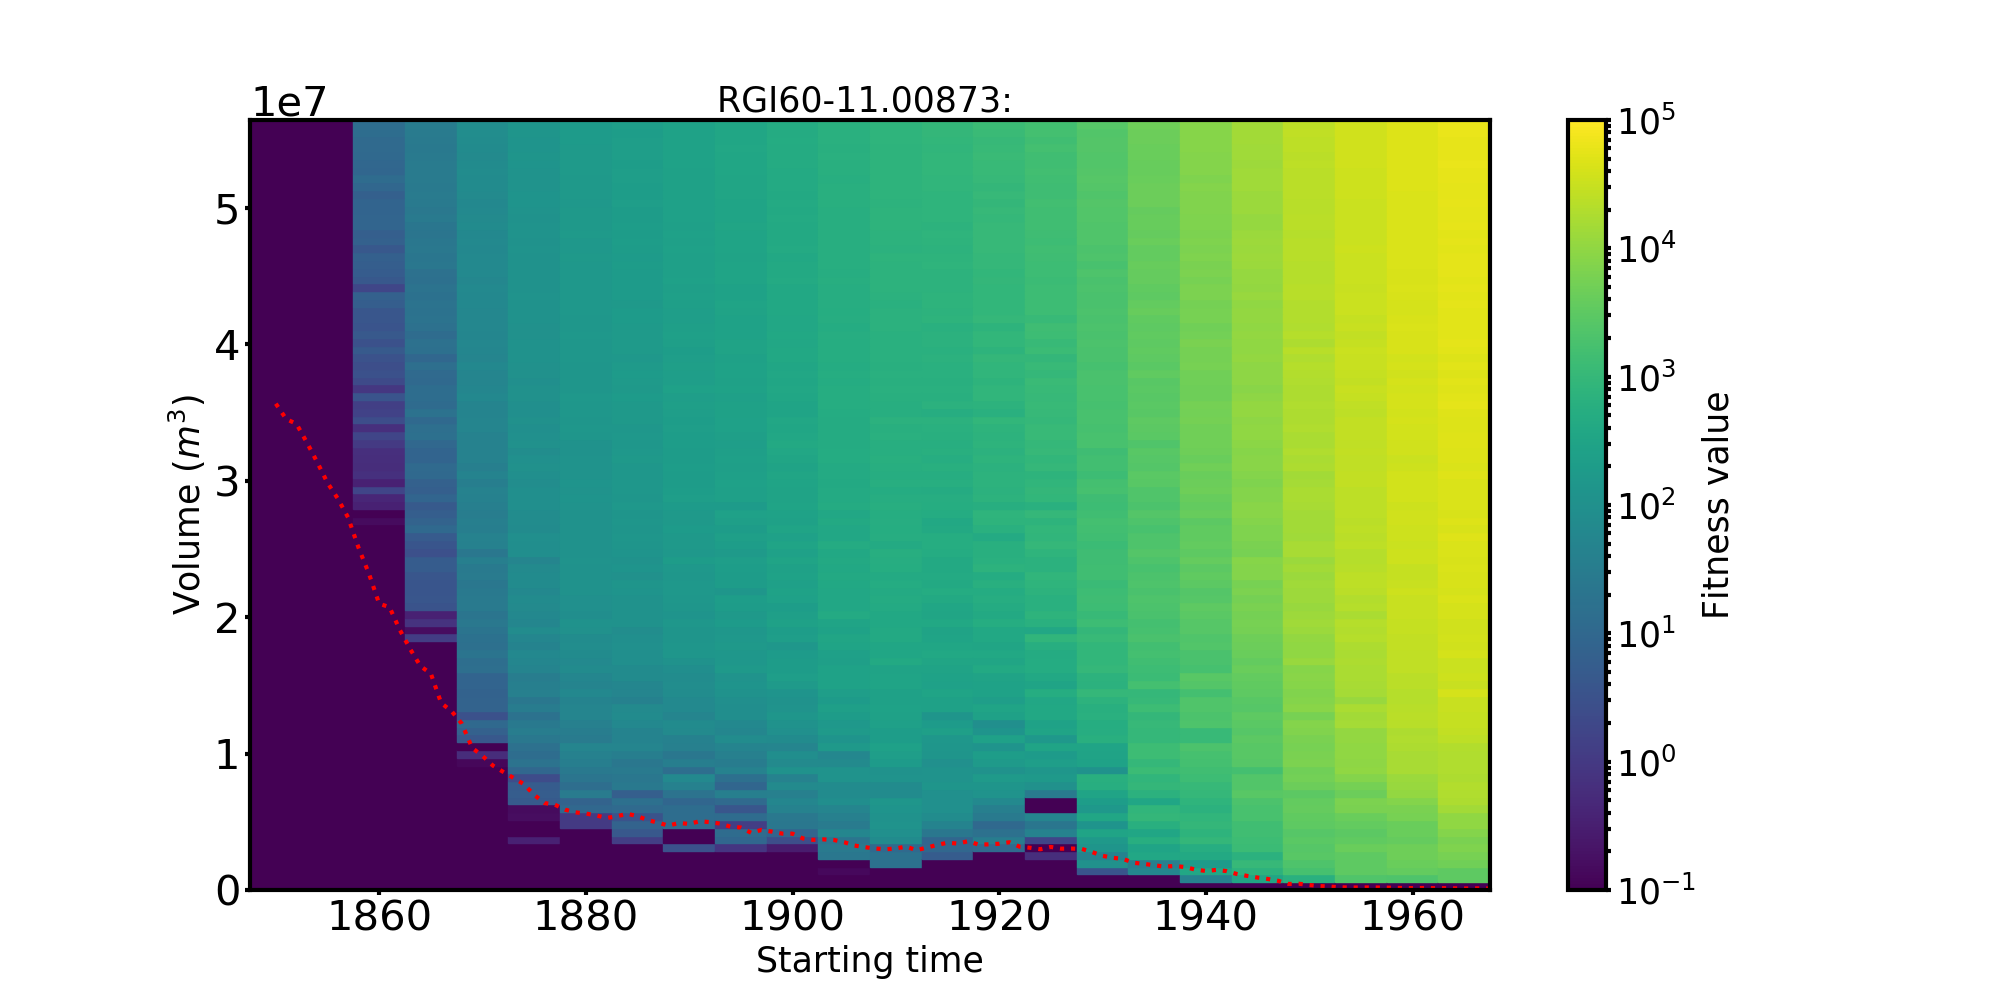